<a href="https://colab.research.google.com/github/google/evojax/blob/main/examples/notebooks/TutorialCallEvoJAXAlgorithmDirectly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to call EvoJAX algorithm directly

In this notebook, we show how to call directly EvoJAX Algorithm, using CMA-ES as an example.

In [1]:
! nvidia-smi

Sat Jan 17 03:59:45 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   22C    P8             10W /  300W |       0MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  ! pip install --upgrade pip
  ! pip install --upgrade flax==0.6.1
  ! pip install --upgrade evojax
else: 
  ! pip install --upgrade pip
  ! pip install --upgrade evojax
  ! pip install seaborn

from IPython.display import clear_output
clear_output()

In [2]:
import jax
from jax import numpy as jnp

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
PARAM_SIZE = 2

# define evaluation at a single point

def f(x: jnp.ndarray) -> jnp.ndarray:
  c = jnp.array([+0.3, -0.7])
  
  # # simple convex funciton
  # y = - jnp.sum(jnp.abs(x - c))
  # # make it harder:
  d = jnp.sum(jnp.abs(x - c))
  y = jnp.cos(d) * jnp.exp(-0.1*d)
  # so y is maximized when x = c
  return y

# ... test it
_x = jax.random.normal(
    key=jax.random.PRNGKey(123), 
    shape=(PARAM_SIZE,)
)
print(f'f({_x}) = {f(_x)}')

# evalute f in batch
f_batch = jax.vmap(f, in_axes=(0,), out_axes=0)

# ... test it
TEST_BATCH_SIZE = 3
_x_batch = jax.random.normal(
    key=jax.random.PRNGKey(123), 
    shape=(TEST_BATCH_SIZE, PARAM_SIZE,)
)
print(f'f_batch(\n{_x_batch}\n) = \n{f_batch(_x_batch)}')

f([1.6359469 0.8408094]) = -0.7238561511039734
f_batch(
[[ 1.6359469   0.8408094 ]
 [ 0.02212393 -0.52927685]
 [-0.6866449  -1.0878773 ]]
) = 
[-0.72385615  0.8615275   0.16997157]


In [4]:
from evojax.algo import PGPE, CMA_ES_JAX

In [5]:
n_population = 128
n_feature = PARAM_SIZE
n_iterations = 40
report_interval = 1

In [6]:
#@title CMA ES without particular initilization

solver = CMA_ES_JAX(
  pop_size=n_population,
  param_size=n_feature,
  init_stdev=0.1,
)

have_printed = False
recorded_best_fitness_no_init = []

for iter_ in range(1, 1 + n_iterations):
  solutions = solver.ask() 
  fitnesses = f_batch(solutions)
  solver.tell(fitnesses)

  if iter_ % report_interval == 0 or iter_ == 1 or iter_ == n_iterations:
    best_solutions = jnp.expand_dims(solver.best_params, axis=0)
    best_fitnesses = f_batch(best_solutions)
    recorded_best_fitness_no_init.append(
        np.array(best_fitnesses)[0]
    )

    if not have_printed:
      have_printed = True
      print(f'solutions.shape = {solutions.shape}')
      print(f'fitnesses.shape = {fitnesses.shape}')
      print(f'best_solutions.shape = {best_solutions.shape}')

    print(f'f_batch({best_solutions}) = {best_fitnesses}')

solutions.shape = (128, 2)
fitnesses.shape = (128,)
best_solutions.shape = (1, 2)
f_batch([[ 0.08715153 -0.08800762]]) = [0.62494063]
f_batch([[ 0.19205455 -0.21973461]]) = [0.7844109]
f_batch([[ 0.34144002 -0.5556028 ]]) = [0.9646868]
f_batch([[ 0.30348548 -0.6395169 ]]) = [0.99159133]
f_batch([[ 0.3543874  -0.69542867]]) = [0.99239415]
f_batch([[ 0.30112708 -0.7058791 ]]) = [0.9992751]
f_batch([[ 0.29656705 -0.6992154 ]]) = [0.99956954]
f_batch([[ 0.29623976 -0.7008895 ]]) = [0.9995243]
f_batch([[ 0.29813156 -0.69943434]]) = [0.99975365]
f_batch([[ 0.29965058 -0.6989245 ]]) = [0.9998565]
f_batch([[ 0.2997097 -0.6997737]]) = [0.99994826]
f_batch([[ 0.29993978 -0.700068  ]]) = [0.99998724]
f_batch([[ 0.29990348 -0.69994646]]) = [0.999985]
f_batch([[ 0.29996076 -0.69998217]]) = [0.99999434]
f_batch([[ 0.29997858 -0.6999926 ]]) = [0.99999714]
f_batch([[ 0.30000296 -0.7000119 ]]) = [0.99999857]
f_batch([[ 0.29999888 -0.699994  ]]) = [0.9999993]
f_batch([[ 0.30000058 -0.6999932 ]]) = [0.99

In [7]:
#@title CMA ES with initilization
n_population = 128
n_feature = PARAM_SIZE
n_iterations = 40
report_interval = 1

solver = CMA_ES_JAX(
  pop_size=n_population,
  param_size=n_feature,
  mean=jnp.array([0.35, -0.65]),
  init_stdev=0.1,
)

have_printed = False
recorded_best_fitness_with_init = []

for iter_ in range(1, 1 + n_iterations):
  solutions = solver.ask() 
  fitnesses = f_batch(solutions)
  solver.tell(fitnesses)

  if iter_ % report_interval == 0 or iter_ == 1 or iter_ == n_iterations:
    best_solutions = jnp.expand_dims(solver.best_params, axis=0)
    best_fitnesses = f_batch(best_solutions)
    recorded_best_fitness_with_init.append(
        np.array(best_fitnesses)[0]
    )

    if not have_printed:
      have_printed = True
      print(f'solutions.shape = {solutions.shape}')
      print(f'fitnesses.shape = {fitnesses.shape}')
      print(f'best_solutions.shape = {best_solutions.shape}')

    print(f'f_batch({best_solutions}) = {best_fitnesses}')


solutions.shape = (128, 2)
fitnesses.shape = (128,)
best_solutions.shape = (1, 2)
f_batch([[ 0.3060159  -0.69433093]]) = [0.998764]
f_batch([[ 0.3043118 -0.6954692]]) = [0.9990771]
f_batch([[ 0.29908067 -0.70501083]]) = [0.9993896]
f_batch([[ 0.30115485 -0.6994252 ]]) = [0.9998256]
f_batch([[ 0.3001165 -0.7019899]]) = [0.9997872]
f_batch([[ 0.30003384 -0.70013297]]) = [0.9999834]
f_batch([[ 0.29986018 -0.70012504]]) = [0.9999734]
f_batch([[ 0.29991737 -0.7000913 ]]) = [0.9999826]
f_batch([[ 0.29999992 -0.70005316]]) = [0.99999464]
f_batch([[ 0.3000256  -0.70000917]]) = [0.99999654]
f_batch([[ 0.30000257 -0.7000088 ]]) = [0.99999887]
f_batch([[ 0.29999778 -0.6999987 ]]) = [0.99999964]
f_batch([[ 0.29999745 -0.6999983 ]]) = [0.9999995]
f_batch([[ 0.29999918 -0.69999963]]) = [0.9999999]
f_batch([[ 0.2999992 -0.6999998]]) = [0.9999999]
f_batch([[ 0.29999945 -0.7       ]]) = [1.]
f_batch([[ 0.30000007 -0.6999999 ]]) = [1.]
f_batch([[ 0.3 -0.7]]) = [1.]
f_batch([[ 0.29999995 -0.7000001 ]]) =

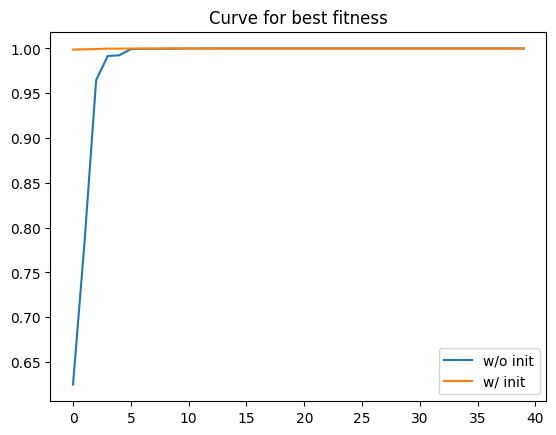

In [8]:
plt.plot(recorded_best_fitness_no_init, label='w/o init')
plt.plot(recorded_best_fitness_with_init, label='w/ init')
plt.legend()
plt.title('Curve for best fitness')
plt.show()